In [1]:
# LIBRARIES #
import time
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage.restoration import denoise_bilateral
from scipy.signal import wiener

from  sklearn import preprocessing 
from sklearn.metrics import matthews_corrcoef
from keras import backend as K
from numba import jit
import tensorflow as tf 

Using TensorFlow backend.


In [2]:
### CONFIG ###

NUMBER_OF_PICTURES_TO_CREATE = 10

COVER_IMG_TYPE = 'pgm'
STEGO_IMG_TYPE = 'png'

PAYLOAD = [3,5,10,15,25,35]

BASE_PATH = '/Users/paul.tgr/aPavel/VAE_diploma/DB/'

path_cover = BASE_PATH + 'cover/'  # pgm

path_stego_mg_3 = BASE_PATH + 'stego_mg/mg_payload_3/' #png
path_stego_mg_5 = BASE_PATH + 'stego_mg/mg_payload_5/'
path_stego_mg_10 = BASE_PATH + 'stego_mg/mg_payload_10/'
path_stego_mg_15 = BASE_PATH + 'stego_mg/mg_payload_15/'
path_stego_mg_25 = BASE_PATH + 'stego_mg/mg_payload_25/'
path_stego_mg_35 = BASE_PATH + 'stego_mg/mg_payload_35/'


path_stego_uniward_3 = BASE_PATH + 'stego_uniward/uniward_payload_3/' #png
path_stego_uniward_5 = BASE_PATH + 'stego_uniward/uniward_payload_5/'
path_stego_uniward_10 = BASE_PATH + 'stego_uniward/uniward_payload_10/'
path_stego_uniward_15 = BASE_PATH + 'stego_uniward/uniward_payload_15/'
path_stego_uniward_25 = BASE_PATH + 'stego_uniward/uniward_payload_25/'
path_stego_uniward_35 = BASE_PATH + 'stego_uniward/uniward_payload_35/'

path_stego_mg = [
    path_stego_mg_3,
    path_stego_mg_5,
    path_stego_mg_10,
    path_stego_mg_15,
    path_stego_mg_25,
    path_stego_mg_35
]

path_stego_uniward = [
      path_stego_uniward_3,
      path_stego_uniward_5,
      path_stego_uniward_10,
      path_stego_uniward_15,
      path_stego_uniward_25,
      path_stego_uniward_35
]

In [3]:
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        #print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
        return tempTimeInterval

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [4]:
def dataset_importing(path = 0, file_extention = "pgm", n_samples = 100):
    if path_cover:
        tic()
        
        dataset = [ np.array( skimage.color.rgb2gray(skimage.io.imread(path + '{}.{}'.format(i,file_extention)))) for i in range(1,n_samples+1) ]
        dataset =  np.array(dataset).astype( "float64") 
        print("Creating dataset of {} samples in {:.2f}s".format(n_samples,toc()))
        
    return dataset

In [5]:
### Bilateral ###
def bilateral_filter_(dataset,kernel = 5):
    filtered_bilateral= []
    time_array_bilateral = []

    for image in dataset:
        tic()
        filtered_bilateral.append( denoise_bilateral( image, kernel ) )
        time_array_bilateral.append(toc())
    return filtered_bilateral, time_array_bilateral

In [8]:
### Wiener ###
def wiener_filter_(dataset,kernel = (5,5)):
    filtered_wiener = []
    time_array_wiener = []

    for image in dataset:
        tic()
        filtered_wiener.append(wiener( image, kernel)) 
        time_array_wiener.append(toc())
    return filtered_wiener, time_array_wiener

In [9]:
# MSE METRIC FOR BATCH OF SAMPLES #

def MSE(imageA,imageB):
    err = []
    len_ = min(len(imageA),len(imageB))
    for i in range(len_):
        err.append(
            np.sqrt(np.sum((imageA[i].astype("float") - imageB[i].astype("float")) ** 2) / float(imageA[i].shape[0]*imageA[i].shape[1]))
        )
    return err

In [10]:
def np_to_tf_tensor(arg):
    return tf.convert_to_tensor(arg, dtype=tf.float32)

# SSIM METRIC FOR BATCH OF SAMPLES #

def ssim_decorator(y_true,y_pred):
    max_val = 255

    y_true = np_to_tf_tensor(y_true)
    y_pred = np_to_tf_tensor(y_pred)
    return tf.image.ssim(y_true,y_pred,max_val)

def SSIM(imageA,imageB):
    imageA = np.array([ np.reshape( imageA[i], (512,512,1)) for i in range(len(imageA))])
    imageB = np.array([ np.reshape( imageB[i], (512,512,1)) for i in range(len(imageB))])
    
    err = []
    len_ = min(len(imageA),len(imageB))
    for i in range(len_):
        err.append( ssim_decorator(imageA[i],imageB[i]) )
    return err

In [9]:
# NCC METRIC FOR BATCH OF SAMPLES #

def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

def NCC(imageA,imageB):
    imageA = np.array([ np.reshape( imageA[i], (512,512,1)) for i in range(len(imageA))])
    imageB = np.array([ np.reshape( imageB[i], (512,512,1)) for i in range(len(imageB))])
    err = []
    len_ = min(len(imageA),len(imageB))
    for i in range(len_):
        err.append( correlation_coefficient(imageA[i],imageB[i]) )
    return err
    

In [26]:
# FS_SCORE METRIC FOR BATCH OF SAMPLES #
def fs_score(img_cover,img_stego,img_stego_filtered):
    
    
    #threshold = 0.1
    
    delta_cs = np.array(img_cover) - np.array(img_stego)
    
 
    idx_eq_zero = np.where( delta_cs == 0 )
    
    img_stego_filtered[idx_eq_zero] = img_stego[idx_eq_zero]
    
    delta_cs_filtered = np.array(img_cover) - np.array(img_stego_filtered)
    
    
    
    #### How many bits with payload was changed ####
    return np.sum(( delta_cs_filtered !=0) ) / np.sum(delta_cs != 0)

    
#### How strong all bits were changed  ####

#     min_max_scaler = preprocessing.MinMaxScaler()
#     delta_cs_filtered.reshape(-1, 1)
#     delta_cs.reshape(-1, 1)
#     delta_cs_filtered_normalized = min_max_scaler.fit_transform(delta_cs_filtered).ravel()
#     delta_cs_normalized = min_max_scaler.fit_transform(delta_cs).ravel()
    
#     return np.sum(delta_cs_filtered_normalized) / np.sum(delta_cs_normalized)

def FS_SCORE(cover, stego, stego_filtered):
    len_ = len(cover)
    fs = []
    for i in range(len_):
        fs.append( fs_score(cover[i], stego[i], stego_filtered[i] )  )
        
    return fs



In [12]:
# GENERATE SAMPLES FOR FILTERING #
def generate_all_type_of_samples(path_cover,path_stego_mg,path_stego_uniward):
    
    # COVER SAMPLES #
    print("COVER:")
    cover = dataset_importing(path_cover,COVER_IMG_TYPE,NUMBER_OF_PICTURES_TO_CREATE)

    print("\nMG:")
    # MG STEGO SAMPLES #

    stego_mg = []
    for path_stego_mg_payload in path_stego_mg:
        stego_mg.append(dataset_importing( path_stego_mg_payload, STEGO_IMG_TYPE, NUMBER_OF_PICTURES_TO_CREATE))



    print("\nS-UNIWARD:")
    # UNIWARD STEGO SAMPLES #
    stego_uniward = []
    for path_stego_uniward_payload in path_stego_uniward:
        stego_uniward.append(dataset_importing( path_stego_uniward_payload, STEGO_IMG_TYPE, NUMBER_OF_PICTURES_TO_CREATE))

    return cover, stego_mg, stego_uniward

In [13]:
# PASS SAMPLES VIA BILATERAL FILTER #
def bilateral_all_samples(cover,stego_mg,stego_uniward):
    # COVER SAMPLES #
    bilateral_cover , time_array_bilateral_cover = bilateral_filter_(cover)


    # MG STEGO SAMPLES #
    bilateral_stego_mg = [] 
    time_array_bilateral_stego_mg = []

    for stego_mg_payload in stego_mg:

        bilateral_stego_payload , time_array_bilateral_stego_mg_payload = bilateral_filter_( stego_mg_payload )

        bilateral_stego_mg.append( bilateral_stego_payload )
        time_array_bilateral_stego_mg.append( time_array_bilateral_stego_mg_payload )



    # UNIWARD STEGO SAMPLES #
    bilateral_stego_uniward = [] 
    time_array_bilateral_stego_uniward = []

    for stego_uniward_payload in stego_uniward:

        bilateral_stego_payload , time_array_bilateral_stego_uniward_payload = bilateral_filter_( stego_uniward_payload )

        bilateral_stego_uniward.append( bilateral_stego_payload )
        time_array_bilateral_stego_uniward.append( time_array_bilateral_stego_uniward_payload )
        
    return bilateral_cover, bilateral_stego_mg, bilateral_stego_uniward



In [14]:
# PASS SAMPLES VIA WIENER FILTER #

# COVER SAMPLES #
def wiener_all_samples(cover,stego_mg,stego_uniward):
    
    wiener_cover , time_array_wiener_cover = wiener_filter_(cover)


    # MG STEGO SAMPLES #
    wiener_stego_mg = [] 
    time_array_wiener_stego_mg = []

    for stego_mg_payload in stego_mg:

        wiener_stego_payload , time_array_wiener_stego_mg_payload = wiener_filter_( stego_mg_payload )

        wiener_stego_mg.append( wiener_stego_payload )
        time_array_wiener_stego_mg.append( time_array_wiener_stego_mg_payload )



    # UNIWARD STEGO SAMPLES #
    wiener_stego_uniward = [] 
    time_array_wiener_stego_uniward = []

    for stego_uniward_payload in stego_uniward:

        wiener_stego_payload , time_array_wiener_stego_uniward_payload = wiener_filter_( stego_uniward_payload )

        wiener_stego_uniward.append( wiener_stego_payload )
        time_array_wiener_stego_uniward.append( time_array_wiener_stego_uniward_payload )
        
    return wiener_cover, wiener_stego_mg, wiener_stego_uniward



In [15]:
def mse_all_samples(cover, bilateral_cover,wiener_cover, 
                    stego_mg, bilateral_stego_mg, wiener_stego_mg,  
                    stego_uniward, bilateral_stego_uniward, wiener_stego_uniward):
    # COVER BILATERAL#

    MSE_bilateral_cover = MSE(cover,bilateral_cover)

    # COVER WIENER #
    MSE_wiener_cover = MSE(cover,wiener_cover)



    # MG BILATERAL #
    MSE_bilateral_stego_mg = []
    for i in range(len(stego_mg)):
        MSE_bilateral_stego_mg.append( MSE( stego_mg[i], bilateral_stego_mg[i] ))

    # MG WIENER #
    MSE_wiener_stego_mg = []
    for i in range(len(stego_mg)):
        MSE_wiener_stego_mg.append( MSE( stego_mg[i], wiener_stego_mg[i] ))



        
    # S-UNIWARD BILATERAL #
    MSE_bilateral_stego_uniward = []
    for i in range(len(stego_uniward)):
        MSE_bilateral_stego_uniward.append( MSE( stego_uniward[i], bilateral_stego_uniward[i] ))

    # S-UNIWARD WIENER #
    MSE_wiener_stego_uniward = []
    for i in range(len(stego_uniward)):
        MSE_wiener_stego_uniward.append( MSE( stego_uniward[i], wiener_stego_uniward[i] ))
        
    return MSE_bilateral_cover, MSE_wiener_cover, MSE_bilateral_stego_mg, MSE_wiener_stego_mg, MSE_bilateral_stego_uniward, MSE_wiener_stego_uniward


In [16]:
def ssim_all_samples(cover, bilateral_cover, wiener_cover, 
                    stego_mg, bilateral_stego_mg, wiener_stego_mg,  
                    stego_uniward, bilateral_stego_uniward, wiener_stego_uniward):
    # COVER BILATERAL#
    SSIM_bilateral_cover = SSIM(cover,bilateral_cover)

    # COVER WIENER #
    SSIM_wiener_cover = SSIM(cover,wiener_cover)



    # MG BILATERAL #
    SSIM_bilateral_stego_mg = []
    for i in range(len(stego_mg)):
        SSIM_bilateral_stego_mg.append( SSIM( stego_mg[i], bilateral_stego_mg[i] ))

    # MG WIENER #
    SSIM_wiener_stego_mg = []
    for i in range(len(stego_mg)):
        SSIM_wiener_stego_mg.append( SSIM( stego_mg[i], wiener_stego_mg[i] ))




    # S-UNIWARD BILATERAL #
    SSIM_bilateral_stego_uniward = []
    for i in range(len(stego_uniward)):
        SSIM_bilateral_stego_uniward.append( SSIM( stego_uniward[i], bilateral_stego_uniward[i] ))

    # S-UNIWARD WIENER #
    SSIM_wiener_stego_uniward = []
    for i in range(len(stego_uniward)):
        SSIM_wiener_stego_uniward.append( SSIM( stego_uniward[i], wiener_stego_uniward[i] ))

    return SSIM_bilateral_cover, SSIM_wiener_cover, SSIM_bilateral_stego_mg, SSIM_wiener_stego_mg, SSIM_bilateral_stego_uniward, SSIM_wiener_stego_uniward


In [17]:
def ncc_all_samples(cover, bilateral_cover, wiener_cover, 
                    stego_mg, bilateral_stego_mg, wiener_stego_mg,  
                    stego_uniward, bilateral_stego_uniward, wiener_stego_uniward):
    # COVER BILATERAL#
    NCC_bilateral_cover = NCC(cover,bilateral_cover)

    # COVER WIENER #
    NCC_wiener_cover = NCC(cover,wiener_cover)



    # MG BILATERAL #
    NCC_bilateral_stego_mg = []
    for i in range(len(stego_mg)):
        NCC_bilateral_stego_mg.append( NCC( stego_mg[i], bilateral_stego_mg[i] ))

    # MG WIENER #
    NCC_wiener_stego_mg = []
    for i in range(len(stego_mg)):
        NCC_wiener_stego_mg.append( NCC( stego_mg[i], wiener_stego_mg[i] ))




    # S-UNIWARD BILATERAL #
    NCC_bilateral_stego_uniward = []
    for i in range(len(stego_uniward)):
        NCC_bilateral_stego_uniward.append( NCC( stego_uniward[i], bilateral_stego_uniward[i] ))

    # S-UNIWARD WIENER #
    NCC_wiener_stego_uniward = []
    for i in range(len(stego_uniward)):
        NCC_wiener_stego_uniward.append( NCC( stego_uniward[i], wiener_stego_uniward[i] ))
    
    return NCC_bilateral_cover, NCC_wiener_cover, NCC_bilateral_stego_mg, NCC_wiener_stego_mg, NCC_bilateral_stego_uniward, NCC_wiener_stego_uniward


In [18]:
# FS_SCORE FOR ALL DATASETS # 

def fs_score_all_samples(cover, stego_mg, bilateral_stego_mg, wiener_stego_mg,  stego_uniward, bilateral_stego_uniward, wiener_stego_uniward):
    # MG BILATERAL #
    FS_SCORE_bilateral_stego_mg = []
    for i in range(len(stego_mg)):
        FS_SCORE_bilateral_stego_mg.append( FS_SCORE(cover, stego_mg[i], bilateral_stego_mg[i] ))

    # MG WIENER #
    FS_SCORE_wiener_stego_mg = []
    for i in range(len(stego_mg)):
        FS_SCORE_wiener_stego_mg.append( FS_SCORE(cover, stego_mg[i], wiener_stego_mg[i] ))




    # S-UNIWARD BILATERAL #
    FS_SCORE_bilateral_stego_uniward = []
    for i in range(len(stego_uniward)):
        FS_SCORE_bilateral_stego_uniward.append( FS_SCORE(cover, stego_uniward[i], bilateral_stego_uniward[i] ))

    # S-UNIWARD WIENER #
    FS_SCORE_wiener_stego_uniward = []
    for i in range(len(stego_uniward)):
        FS_SCORE_wiener_stego_uniward.append( FS_SCORE(cover, stego_uniward[i], wiener_stego_uniward[i] ))
        
    return FS_SCORE_bilateral_stego_mg, FS_SCORE_wiener_stego_mg, FS_SCORE_bilateral_stego_uniward, FS_SCORE_wiener_stego_uniward



In [27]:
#  GENERATE DB COVER - STEGO_MG - STEGO_UNIWARD #
cover,stego_mg,stego_uniward = generate_all_type_of_samples(path_cover,path_stego_mg, path_stego_uniward)

# PASS ALL DB VIA BILATERAL #
bilateral_cover,bilateral_stego_mg,bilateral_stego_uniward = bilateral_all_samples(cover,stego_mg,stego_uniward)

# PASS ALL DB VIA WIENER #
wiener_cover, wiener_stego_mg, wiener_stego_uniward = wiener_all_samples(cover, stego_mg, stego_uniward)

# IDENTIFY MSE METRIC FOR ALL DB #
MSE_bilateral_cover, MSE_wiener_cover, MSE_bilateral_stego_mg, MSE_wiener_stego_mg, MSE_bilateral_stego_uniward, MSE_wiener_stego_uniward =  mse_all_samples(cover, bilateral_cover, wiener_cover, stego_mg, bilateral_stego_mg, wiener_stego_mg,  stego_uniward, bilateral_stego_uniward, wiener_stego_uniward)


# IDENTIFY SSIM METRIC FOR ALL DB #
#SSIM_bilateral_cover, SSIM_wiener_cover, SSIM_bilateral_stego_mg, SSIM_wiener_stego_mg, SSIM_bilateral_stego_uniward, SSIM_wiener_stego_uniward = ssim_all_samples(cover, bilateral_cover, wiener_cover, stego_mg, bilateral_stego_mg, wiener_stego_mg,  stego_uniward, bilateral_stego_uniward, wiener_stego_uniward)

# IDENTIFY NCC METRIC FOR ALL DB #
#NCC_bilateral_cover, NCC_wiener_cover, NCC_bilateral_stego_mg, NCC_wiener_stego_mg, NCC_bilateral_stego_uniward, NCC_wiener_stego_uniward = ncc_all_samples(cover, bilateral_cover, wiener_cover, stego_mg, bilateral_stego_mg, wiener_stego_mg,  stego_uniward, bilateral_stego_uniward, wiener_stego_uniward)

# IDENTIFY FS METRIC FOR ALL DB #
FS_SCORE_bilateral_stego_mg, FS_SCORE_wiener_stego_mg, FS_SCORE_bilateral_stego_uniward,FS_SCORE_wiener_stego_uniward = fs_score_all_samples(cover,stego_mg,  bilateral_stego_mg, wiener_stego_mg,  stego_uniward, bilateral_stego_uniward, wiener_stego_uniward)





COVER:
Creating dataset of 10 samples in 0.03s

MG:
Creating dataset of 10 samples in 0.07s
Creating dataset of 10 samples in 0.05s
Creating dataset of 10 samples in 0.05s
Creating dataset of 10 samples in 0.06s
Creating dataset of 10 samples in 0.05s
Creating dataset of 10 samples in 0.05s

S-UNIWARD:
Creating dataset of 10 samples in 0.06s
Creating dataset of 10 samples in 0.07s
Creating dataset of 10 samples in 0.06s
Creating dataset of 10 samples in 0.05s
Creating dataset of 10 samples in 0.06s
Creating dataset of 10 samples in 0.06s


In [28]:
def average_metric(metric):
    return np.array(metric).mean()

def mean_metric_via_all_payload(metric_array):
    ave = []
    for metric in metric_array:
        ave.append(average_metric(metric))
    return ave
    
    
def normalization_metric(metric):
    metric = np.array(metric)
    metric = metric.reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    metric_normalized = min_max_scaler.fit_transform(metric).ravel()
    return metric_normalized

def show_low_high_metric_value(metric_array, metric_name = ""):
    for metric in metric_array:
        max_idx = np.array(metric).argmax()
        min_idx = np.array(metric).argmin()
        print(max_idx,min_idx)
        print("Picture {} - Max {}: {:.3f}".format( max_idx , metric_name, metric[max_idx]  ))
        print("Picture {} - Min {}: {:.3f}\n".format( min_idx , metric_name, metric[min_idx]  ))


        

### Show 2 images ###
def plot_2images(image,filtered,idx_img,name_filtration = 0):
    if name_filtration:
        print("[*] {} [*]".format(name_filtration))
        
    plt.imshow(image[idx_img],cmap = plt.cm.gray)
    plt.show()
    plt.imshow(filtered[idx_img],cmap = plt.cm.gray)
    plt.show()

def plot_ave_on_payloads_metric(metric):
    for i in range(len(PAYLOAD)):
        plt.title("Payload {}:".format(PAYLOAD[i]))
        plt.grid()
        plt.xlabel("Samples N")
        plt.ylabel(" Metric val")
        plt.plot(metric[i])
        plt.show()    
    
def plot_ave_on_payloads_metric_via_payloads(metrics,name_plot):
    title_ = ["MG","UNIWARD"]
    
    plt.title("{}:".format(name_plot))
    plt.grid()
    plt.xlabel("Payload %")
    plt.ylabel("Ave metric")
    plt.xticks(np.arange(6),tuple(PAYLOAD))
    for i in range(len(metrics)):
        plt.plot(metrics[i],label = title_[(i)%2] )
    plt.legend()

    plt.show()    
    
def plot_ave_metric_all_filters(metric_bilateral_stego_mg, 
                                metric_wiener_stego_mg, 
                                metric_bilateral_stego_uniward, 
                                metric_wiener_stego_uniward,
                                name = "Metric",full = True) :
    
    ave_metric_bilateral_stego_mg = mean_metric_via_all_payload(metric_bilateral_stego_mg)
    ave_metric_wiener_stego_mg = mean_metric_via_all_payload(metric_wiener_stego_mg)
    
    ave_metric_bilateral_stego_uniward = mean_metric_via_all_payload(metric_bilateral_stego_uniward)
    ave_metric_wiener_stego_uniward = mean_metric_via_all_payload(metric_wiener_stego_uniward)

    if not full:
        ave = [
            ave_metric_bilateral_stego_mg,
            ave_metric_wiener_stego_mg,
            ave_metric_bilateral_stego_uniward,
            ave_metric_wiener_stego_uniward
        ]
        plot_ave_on_payloads_metric_via_payloads(ave,name)
    else:
        ave = [
            ave_metric_bilateral_stego_mg,
            ave_metric_bilateral_stego_uniward
        ]
        plot_ave_on_payloads_metric_via_payloads(ave,name+"-BILATERAL")
        
        ave = [
            ave_metric_wiener_stego_mg,
            ave_metric_wiener_stego_uniward
        ]
        plot_ave_on_payloads_metric_via_payloads(ave,name+"-WIENER")
        

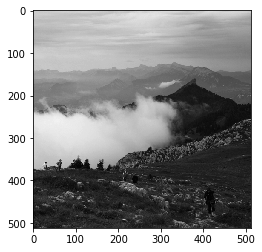

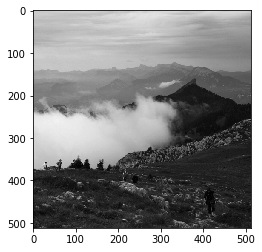

In [29]:
plot_2images(stego_mg[1],wiener_stego_mg[1],1)

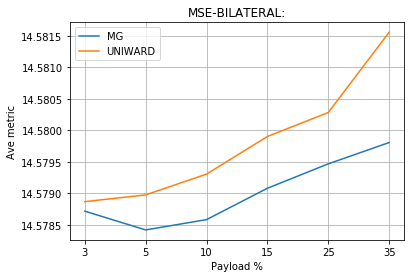

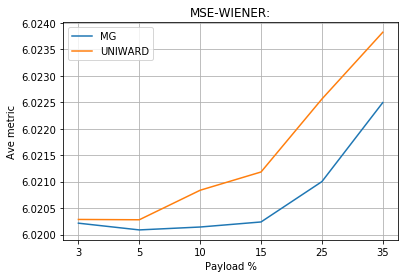

In [23]:
plot_ave_metric_all_filters(MSE_bilateral_stego_mg, 
                            MSE_wiener_stego_mg, 
                            MSE_bilateral_stego_uniward, 
                            MSE_wiener_stego_uniward,
                            "MSE")

In [24]:
plot_ave_metric_all_filters(SSIM_bilateral_stego_mg, 
                            SSIM_wiener_stego_mg, 
                            SSIM_bilateral_stego_uniward, 
                            SSIM_wiener_stego_uniward,
                            "SSIM")

NameError: name 'SSIM_bilateral_stego_mg' is not defined

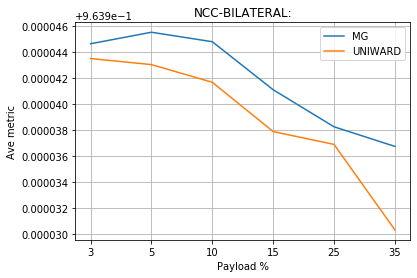

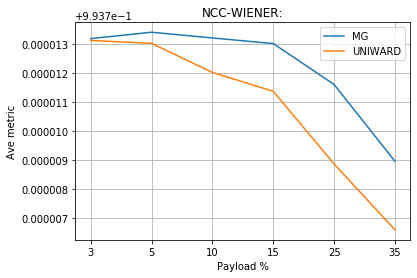

In [26]:
plot_ave_metric_all_filters(NCC_bilateral_stego_mg, 
                            NCC_wiener_stego_mg, 
                            NCC_bilateral_stego_uniward, 
                            NCC_wiener_stego_uniward,
                            "NCC")

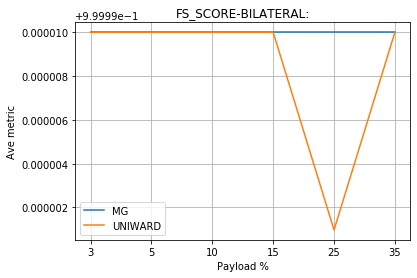

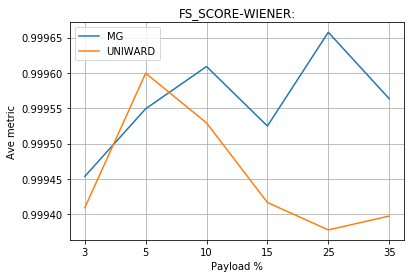

In [30]:
plot_ave_metric_all_filters(FS_SCORE_bilateral_stego_mg, 
                            FS_SCORE_wiener_stego_mg, 
                            FS_SCORE_bilateral_stego_uniward, 
                            FS_SCORE_wiener_stego_uniward,
                            "FS_SCORE")